# Introduction
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

The objective of this study is to understand and implement unsupervised learning models to correctly identify digits from a dataset of tens of thousands of handwritten images. In the end, we will compare between supervised and unsupervised learning models.  

This is also a running competition on Kaggle at the following link https://www.kaggle.com/competitions/digit-recognizer/overview. This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

## Description of dataset
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).  

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column. You can submit the submission file on Kaggle for test accuracy.

## Obtaining the dataset
You can download the dataset in a csv file from Kaggle at following link https://www.kaggle.com/competitions/digit-recognizer/data
<br>
There are 3 files:  
<br>
train.csv - the training set of 42000 records  
test.csv - the test set of 28000 records  
sample_submission.csv - a sample submission file in the correct format  
<br>


## Libraries Import

In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings
from itertools import permutations
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve

## Read Datasets

In [2]:
df_train = pd.read_csv("digit-recognizer/train.csv")
df_train.info()        
df_test = pd.read_csv("digit-recognizer/test.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Cleaning and Exploratory Data Analysis (EDA)

After successfully checking that I have got the right data format. Let's do some data checking and cleaning as well as some exploratory analysis.

In [5]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


There are 784 columns that represent the pixels in the image while the last column "label" represents true value of digit.

In [6]:
na_values =  df_train.isna().sum()
for i in range(0,len(na_values)):
    if na_values[i] != 0:
        print("NA values for column ", i, ":" , na_values[i])
if (sum(na_values) == 0):
    print(na_values)
    print("No NA values found")

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
No NA values found


In [7]:
null_values =  df_train.isnull().sum()
for i in range(0,len(null_values)):
    if null_values[i] != 0:
        print("Null values for column ", i, ":" , na_values[i])
if (sum(null_values) == 0):
    print(null_values)
    print("No Null values found")

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
No Null values found


There are no NA and Null values in the train dataset.

In [8]:
df_train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6], dtype=int64)

The labels are from 0 to 9, which represent the digits.

<AxesSubplot:xlabel='label', ylabel='count'>

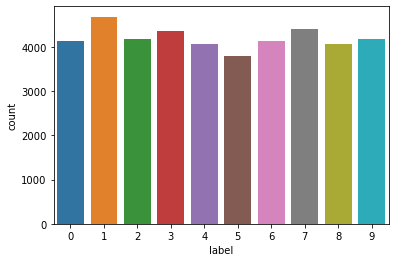

In [9]:
sns.countplot(x = 'label', data = df_train)

The histogram of labels in train set shows that dataset is quite balanced.

In [10]:
# Create arrays for the features and the response variable
# store for use later 
Y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

***Now I want to split the train.csv set into train set and test set because the test.csv file only contains features for submission predictions. So in case one gets lost in the variable names, here I specificially named capital letters X and Y for the train.csv and test.csv datasets while lower letters x and y for train set and test set that were split from the train.csv dataset***

In [11]:
x_train, x_test,  y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.5, random_state = 0)
X_test = df_test.values
Y_test = np.zeros(len(X_test))
print("Train.csv  Dataset Features Shape:", X_train.shape)
print("Train.csv Dataset Response Shape:", Y_train.shape)
print("Test.csv Dataset Features Shape:", X_test.shape)
print("Train Features Shape:", x_train.shape)
print("Train Response Shape:", y_train.shape)
print("Test Features Shape:", x_test.shape)
print("Test Response Shape:", y_test.shape)

Train.csv  Dataset Features Shape: (42000, 784)
Train.csv Dataset Response Shape: (42000,)
Test.csv Dataset Features Shape: (28000, 784)
Train Features Shape: (21000, 784)
Train Response Shape: (21000,)
Test Features Shape: (21000, 784)
Test Response Shape: (21000,)


**Let's check out a sample of images of digits from 0 to 9.**

In [12]:
def view_digit(x, label=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3,3))
    for i, ax in enumerate(axes):
        ax.imshow(x.reshape(28,28), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

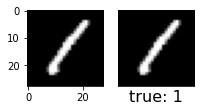

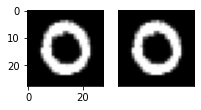

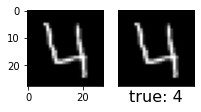

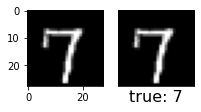

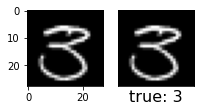

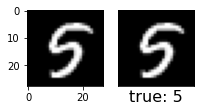

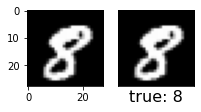

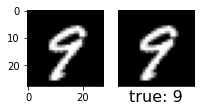

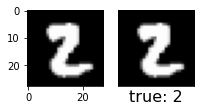

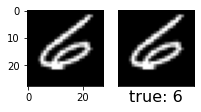

In [13]:
digits = list(range(10))
i= 0
while i < Y_train.shape[0]:
    if len(digits) == 0:
        break;
    else:
        if Y_train[i] in digits:
            digits.remove(Y_train[i])
            view_digit(X_train[i], Y_train[i])
        i = i + 1            

# I. Unsupervised Learning 
I will apply a few unsupervised learning methods such as dimensionality reduction through Principal Component Analysis (PCA), Single Value Decomposition (SVD), feature extraction such Non-Negative Matrix Factorization (NMF) then use distance between samples to compare and make predictions, clustering based methods to classify the labels by using minimum distance between clusters.    

## 1. Dimensionality Reduction

### Principal Component Analysis (PCA)
I will implement a PCA Classifier class where I use PCA class from sklearn to fit and transform the features matrix. In the PCAClassifier class, I also implement a predict function for test set based on the distance between transformed test and transformed training samples to find the k-nearest neighbors for each test sample and make prediction based on the most frequent label among the k-nearest neighbors.

In [14]:
class PCAClassifier:
    def __init__(self, n_components = 196, k =5):
        self.n_components = n_components
        self.k = k
        self.pca = PCA(n_components =n_components, whiten = False, random_state =0)
        
    def fit_transform(self,X_train,y_train):
        self.X_train_PCA = self.pca.fit_transform(X_train)
        self.Y_train = y_train
        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_
        return self.X_train_PCA
    def transform(self,X_test):
        self.X_test_PCA = self.pca.transform(X_test)
        return self.X_test_PCA
    def predict(self,X_test):
        self.X_test_PCA = X_test
        # Compute distances between test samples and training samples
        distances = cdist(self.X_test_PCA, self.X_train_PCA, 'euclidean')

        # Find indices of k nearest neighbors for each test sample
        nearest_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]

        # Find the most frequent class label among nearest neighbors for each test sample
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.Y_train[nearest_indices])
        self.y_test = majority_vote
        return self.y_test

**Let's try out the PCA with full 784 components**

In [15]:
# Create a PCA classifier with 784 components
n_components = 784
pca = PCAClassifier(n_components = n_components, k =3)

In [16]:
# PCA fit and transform train set 
x_train_PCA = pca.fit_transform(x_train,y_train)
x_train_PCA
x_train_PCA_df = pd.DataFrame(data= x_train_PCA, index = range(0,len(x_train)))
x_train_PCA_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,-8.446454,-113.168983,-631.028334,-65.918377,762.388057,290.948321,63.339668,-379.101170,295.264428,-85.110082,...,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.904801e-12,-0.000000e+00,0.000000e+00,0.000000e+00
1,457.137522,607.263917,-72.706007,-59.937729,-164.119103,-557.006620,-436.384947,119.150531,12.235730,-309.050385,...,-2.317055e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.242907e-13,2.082449e-12,-1.288012e-13,3.156654e-14
2,-318.406078,-151.093416,509.994478,19.966097,-139.154862,-170.394524,-137.249477,587.051490,277.185914,-195.412934,...,3.138122e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.345679e-14,-1.102599e-12,-3.112498e-13,8.266696e-14
3,-127.949291,-364.065182,171.855942,-507.733302,-375.613780,-505.941827,-275.659858,186.332825,83.680913,321.376555,...,-3.718984e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.205778e-14,-7.644325e-13,-4.278853e-14,-1.268139e-15
4,313.860844,-448.257277,-960.542826,389.903674,-62.271086,-242.147961,355.287963,15.485676,-121.278311,-545.086790,...,1.045639e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.816008e-14,2.516673e-13,1.954045e-13,-1.968530e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,474.590832,34.116873,-40.985075,653.059135,610.658426,-653.112919,284.676551,-83.777379,425.427426,-454.188962,...,-3.301309e-15,8.724458e-15,-2.634484e-15,6.024039e-15,-4.723747e-15,4.734126e-15,-1.777227e-15,3.466720e-15,4.774992e-15,-6.292056e-16
20996,-712.853151,-17.461248,-219.076492,139.971864,-430.243817,-404.162258,-6.146067,-228.517923,-335.529063,147.880409,...,-5.358072e-16,-4.298180e-15,1.742361e-15,-7.804104e-16,-9.215941e-16,-3.280646e-15,9.180527e-16,9.488023e-16,4.373029e-15,6.307986e-16
20997,-264.474994,702.108474,-626.587227,-353.527378,348.142466,-155.729402,175.552863,-79.786296,-146.100398,48.757196,...,-3.046559e-16,-3.251052e-15,-3.113595e-15,-2.161010e-14,7.207411e-15,-6.699786e-15,-3.031617e-15,-4.249090e-16,3.678851e-16,-1.339594e-15
20998,1482.261949,-252.547586,353.622319,-620.417442,-436.634034,-502.997115,-74.444187,-253.837434,63.880134,91.910289,...,1.339393e-15,3.079474e-16,7.077016e-15,-1.577823e-15,-5.862590e-15,4.033746e-15,-5.538373e-15,-4.796376e-15,-5.984967e-16,9.175358e-16


In [17]:
# Plot for observation clustering
def scatterPlot(xDF,yDF, algoName):
    tempDF = pd.DataFrame(data = xDF.loc[:,0:1], index = xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis = 1, join ="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.set(rc={"figure.figsize":(8, 8)})
    splot = sns.lmplot(x="First Vector", y="Second Vector", hue ="Label", data = tempDF, fit_reg = False, height = 8, aspect =1)
    ax = plt.gca()
    ax.set_title("Separation of Observation using " + algoName)

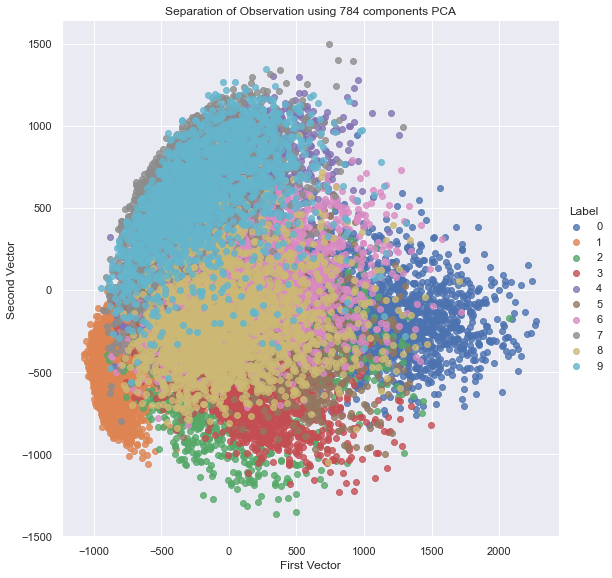

In [18]:
y_train_DF = pd.Series(data = y_train, index = range(0,len(x_train)))
scatterPlot(x_train_PCA_df,y_train_DF, "784 components PCA")

**While each image contains 784 pixels (784 components) but not all the pixels are useful. Therefore, one can think about reducing dimensionality here for the features. So I am thinking about reducing each image to half of the size, then even 1/4, 1/8 and 1/16 of original size. That means we have 392, then 196 , then 98, then 49 components. Then we calculate the variance caputured by those components to decide how many components we want to reduce to but still keep a good accuracy.**

In [19]:
# Table of explained variance ratio
ExpVarRatio = pd.DataFrame(data = pca.explained_variance_ratio_).T 
ExpVarRatio

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.097604,0.071471,0.061599,0.053863,0.048798,0.042974,0.032932,0.029015,0.027468,0.023393,...,3.508393e-34,3.508393e-34,3.508393e-34,3.508393e-34,3.508393e-34,3.508393e-34,3.421379e-34,2.783590e-34,1.296535e-34,1.740678e-35


In [20]:
# Print the variance caputered by first i+1 components, 784/2=392/2=196/2=98/2=49
for i in [48,97,195,391,783]: 
    print('Variance Captured by First ', i+1, ' Principal Components: ', ExpVarRatio.loc[:,0:i].sum(axis=1).values)

Variance Captured by First  49  Principal Components:  [0.8228483]
Variance Captured by First  98  Principal Components:  [0.91332761]
Variance Captured by First  196  Principal Components:  [0.96572981]
Variance Captured by First  392  Principal Components:  [0.9954333]
Variance Captured by First  784  Principal Components:  [1.]


We can see that with just 196 components, we can caputure about 96.6% of the original dataset. So let's apply PCA with 196 components.

In [21]:
# Create a PCA classifier with reduced dimensionaltiy 196 components
n_components = 196
pca = PCAClassifier(n_components = n_components, k= 3)

In [22]:
# PCA fit and transform train set
x_train_PCA = pca.fit_transform(x_train,y_train)
x_train_PCA_df = pd.DataFrame(data= x_train_PCA, index = range(0,len(x_train_PCA)))
x_train_PCA_df

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,-8.446454,-113.168983,-631.028334,-65.918377,762.388057,290.948321,63.339668,-379.101170,295.264428,-85.110082,...,-30.320472,-6.617185,11.603701,-1.976528,-6.179552,-20.257901,5.921738,8.547221,-22.822575,-21.986053
1,457.137522,607.263917,-72.706007,-59.937729,-164.119103,-557.006620,-436.384947,119.150530,12.235730,-309.050385,...,8.596741,11.603708,-43.831596,-26.350447,8.096994,-42.685444,16.130566,-78.355042,-1.429369,-31.754230
2,-318.406078,-151.093416,509.994478,19.966097,-139.154862,-170.394524,-137.249477,587.051490,277.185914,-195.412935,...,1.167163,-23.738077,29.062530,-36.074494,-32.342996,44.308326,58.522952,-20.135523,3.297550,24.495182
3,-127.949291,-364.065182,171.855942,-507.733302,-375.613780,-505.941827,-275.659858,186.332825,83.680914,321.376555,...,21.126964,-31.552309,0.464714,-15.331013,-9.752474,-13.205647,-24.414011,-11.041901,11.262404,-42.244607
4,313.860844,-448.257277,-960.542826,389.903674,-62.271086,-242.147961,355.287963,15.485677,-121.278311,-545.086789,...,-4.767385,20.729995,46.695916,-27.757702,17.490618,-23.010615,-62.821947,4.854148,10.395473,-17.318811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,474.590832,34.116873,-40.985075,653.059135,610.658426,-653.112919,284.676551,-83.777379,425.427425,-454.188962,...,6.157093,-45.576178,19.079829,10.336528,25.381115,55.320852,-48.285549,8.845854,18.901285,64.621769
20996,-712.853151,-17.461248,-219.076492,139.971864,-430.243817,-404.162259,-6.146067,-228.517923,-335.529063,147.880409,...,-38.979237,-2.524783,-1.137680,-14.593250,24.928201,-21.401855,11.141038,-42.657395,-63.120530,-38.335687
20997,-264.474994,702.108474,-626.587227,-353.527378,348.142466,-155.729402,175.552863,-79.786296,-146.100398,48.757196,...,-73.623546,41.026659,-4.315572,-35.982006,14.439670,-49.835233,-30.544235,-1.469839,-41.752855,-60.578387
20998,1482.261949,-252.547586,353.622319,-620.417442,-436.634034,-502.997115,-74.444187,-253.837433,63.880134,91.910289,...,-48.855062,-40.308677,2.390773,18.885647,6.349203,-46.075975,5.390935,-35.733250,-10.948876,-33.015571


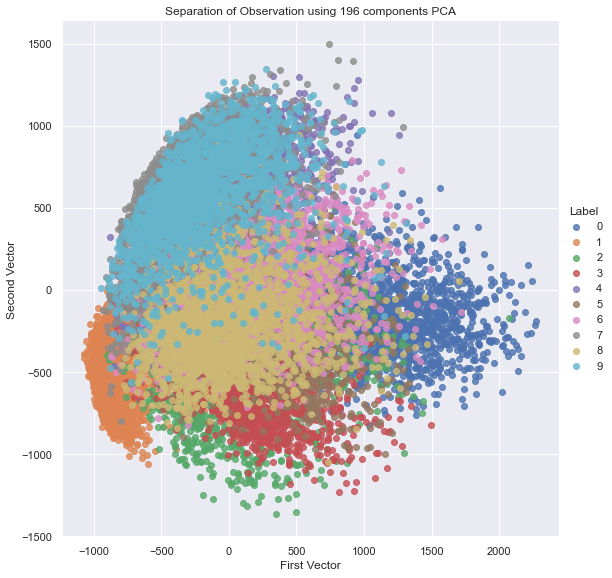

In [23]:
# Plot the obsevation clustering
y_train_PCA_df = pd.Series(data = y_train, index = range(0,len(x_train_PCA)))
scatterPlot(x_train_PCA_df,y_train_PCA_df, "196 components PCA")

**The plot clearly shows that with 196 components, we can still seperate observations pretty much the same as we do with full 784 components. Now let's make prediction for the test set, calculate the accuracy, precision and recall scores for the test set.**

In [24]:
# Make predictions for test set
x_test_PCA = pca.transform(x_test)
y_test_pred = pca.predict(x_test_PCA)
print(y_test_pred)

[3 6 9 ... 5 8 6]


In [25]:
accuracy_list = []
precision_list = []
recall_list = []

# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9615714285714285
Precision Score: 0.9617927860974887
Recall Score: 0.9615714285714285


***With just 196 components, we are able to make prediction with accuracy of 96.2% for the test set. This is a very good result considering the number of components is 1/4 of the original size. Now let's draw the confusion matrix.***

In [26]:
def plot_confusion_matrix(conf_matrix):    
        
    plt.figure(figsize=(8,6))
    
    sns.set(font_scale = 1.1)

    ax = sns.heatmap(conf_matrix, annot= True, fmt='d')
   
    ax.set_xlabel("Prediction", fontsize=14, labelpad=20)
    

    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(list(df_train['label'].unique())); 
    ax.yaxis.set_ticklabels(list(df_train['label'].unique()));

    ax.set_title("Confusion Matrix", fontsize=14, pad=20)
    plt.show()
    

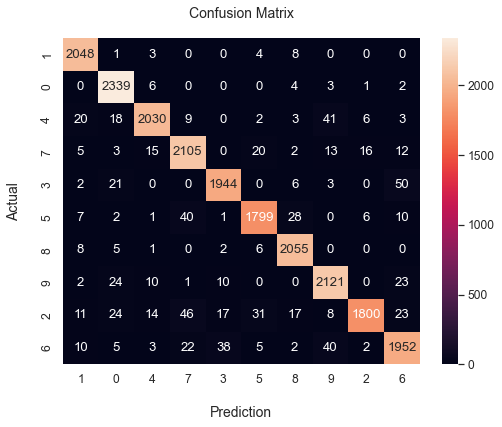

In [27]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

### Singular Value Decomposition (SVD)

The computation of SVD is similar to PCA, so I will just go ahead and apply SVD with 196 components to our original feature matrix. I do the same thing for SVD like PCA, such as creating a SVDClassifier class where I use SVD from sklearn to fit and transform train features matrix and use that to transform test features matrix to make prediction based on k-nearest neighbor by calculating distance between test and train samples.

In [28]:
class SVDClassifier:
    def __init__(self, n_components = 196, k =5):
        self.n_components = n_components
        self.k = k
        self.svd = TruncatedSVD(n_components = n_components, algorithm ='randomized', n_iter = 5, random_state =0)
        
    def fit_transform(self,X_train,y_train):
        self.X_train_SVD = self.svd.fit_transform(X_train)
        self.Y_train = y_train
        self.explained_variance_ratio_ = self.svd.explained_variance_ratio_
        return self.X_train_SVD
    
    def transform(self, X_test):
        self.X_test_SVD = self.svd.transform(X_test)
        return self.X_test_SVD
    
    def predict(self,X_test):
        self.X_test_SVD = X_test
        # Compute distances between test samples and training samples
        distances = cdist(self.X_test_SVD, self.X_train_SVD, 'euclidean')

        # Find indices of k nearest neighbors for each test sample
        nearest_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]

        # Find the most frequent class label among nearest neighbors for each test sample
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.Y_train[nearest_indices])
        self.y_test = majority_vote
        return self.y_test

In [29]:
# Create a SVD classifier with 196 components
n_components = 196
svd = SVDClassifier(n_components = n_components, k =3)

In [30]:
# SVD fit and transform train set
x_train_SVD = svd.fit_transform(x_train,y_train)
x_train_SVD_df = pd.DataFrame(data= x_train_SVD, index = range(0,len(x_train_PCA)))
x_train_SVD_df

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,1943.004533,-306.478663,-106.355508,760.127237,406.172196,243.907303,-180.852012,-380.687741,-14.613971,154.424826,...,28.162476,27.690330,5.360236,11.960418,-4.530997,-19.054870,14.060167,1.019130,-17.359568,22.231599
1,1525.878072,470.018041,600.651197,23.613778,-172.660715,-555.451522,-267.362014,2.327290,228.893360,250.665845,...,-14.189865,-7.801306,-34.680125,-34.454761,16.874531,-53.211041,-8.156221,63.638601,6.862187,5.199380
2,1289.681788,-325.020867,-146.103165,-503.587844,-73.998121,-160.975700,2.245131,408.970299,528.226227,186.663589,...,-9.168544,41.268037,31.133448,-15.703959,-53.468853,35.354126,21.591766,47.131173,-13.125668,-39.287344
3,1392.338749,-161.691136,-361.155252,-137.136013,-641.307357,-493.000078,-78.567999,59.846722,287.173801,-347.711478,...,-36.202672,14.702677,-2.011328,-15.401647,-2.556632,-24.637281,-22.435706,-1.189934,15.272192,20.482304
4,1441.061980,457.281605,-459.821517,857.772119,356.511191,-215.694818,422.353308,103.163639,-174.916609,531.684900,...,22.824083,-22.355292,44.425506,-32.445399,17.670151,-34.069177,-33.078829,-40.728784,20.106813,26.005653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1947.537187,265.398667,32.626706,20.360926,877.806995,-670.828564,189.683961,-125.817300,167.930552,524.361678,...,-15.052842,21.471788,16.118367,12.716391,30.155739,63.369112,-33.003764,-18.653172,-3.636094,-41.607554
20996,749.255095,-381.650172,-18.750370,154.164103,-76.321111,-363.779070,262.361745,-164.149765,-253.849957,-218.071524,...,43.685638,-0.070799,16.918692,-30.231689,27.113360,-19.725780,7.944230,26.632426,-55.487537,19.783597
20997,1638.445584,-415.021818,708.536083,748.746491,-53.590468,-177.500356,4.479710,15.593085,-219.655976,-67.415196,...,76.413409,-11.150082,-2.158502,-33.686283,14.622853,-50.003299,-4.389288,-21.901397,-25.571318,77.224062
20998,2260.528481,1153.625649,-261.705758,-376.734391,-835.595854,-497.894918,-77.693258,-245.443659,-65.365870,-57.023660,...,23.639989,56.271819,-3.450107,27.321966,22.478253,-39.137675,14.873169,24.471719,-4.206000,40.720651


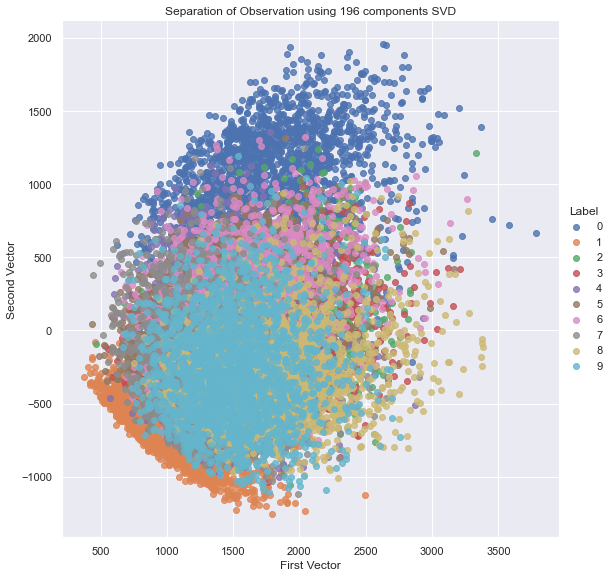

In [31]:
# Plot the obsevation clustering
y_train_SVD_df = pd.Series(data = y_train, index = range(0,len(x_train_SVD)))
scatterPlot(x_train_SVD_df,y_train_SVD_df, "196 components SVD")

**The plot clearly shows that by applying SVD with 196 components, we can seperate overservation quite well.Let's make predictions for the test set and calculate accuracy, precision as well as recall.**

In [32]:
# Make predictions for test set
x_test_SVD = svd.transform(x_test)
y_test_pred = svd.predict(x_test_SVD)
print(y_test_pred)

[3 6 9 ... 5 8 6]


In [33]:
# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9611428571428572
Precision Score: 0.9613672520992969
Recall Score: 0.9611428571428572


***With just 196 components, by using SVD we are able to make prediction with accuracy of 96.1% for the test set. This is comparable to applying PCA dimensionalty reduction because two methods are very similar in their computations . Now let's draw the confusion matrix for test prediction.***

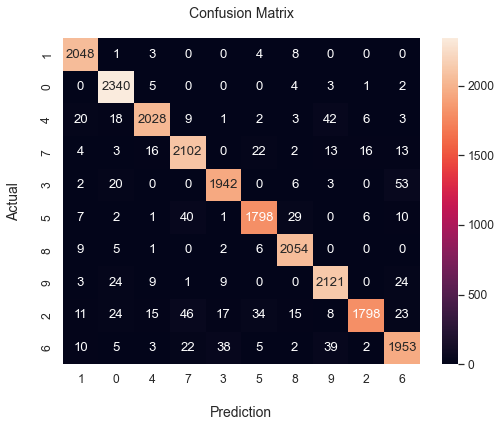

In [34]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

## 2. Feature Extraction

### Non-Negative Matrix Factorization (NMF)

For the NMF, I create a NMFClassifier class that inherits from NMF class sklearn. NMFClassifer has 2 functions that use NMF from sklearn to fit and transfrom our train features matrix, and predict the test set by computing distances between transformed test samples and transformed train sample to find the k-nearest neighbors to make prediction based on the most common neighbor. This is similar to PCA and SVD implementation.

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin
class NMFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=5, k =5, random_state=None, init = None, solver='cd',beta_loss = 'frobenius'):
        self.n_components = n_components
        self.random_state = random_state
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.best_permutation = None
        self.best_accuracy = 0.0
        self.k = k
        
    def fit_transform(self, X_train, y_train):
        self.nmf = NMF(n_components=self.n_components, init=self.init, solver=self.solver,
                       random_state=self.random_state, beta_loss=self.beta_loss, max_iter = 300)
        self.X_train_NMF = self.nmf.fit_transform(X_train,y_train) 
        self.Y_train = y_train
        return self
    
    def transform(self, X_test):
        self.X_test_NMF = self.nmf.transform(X_test)
        return self.X_test_NMF
    
    def predict(self, X_test):
        self.X_test_NMF = X_test
        # Compute distances between test samples and training samples
        distances = cdist(self.X_test_NMF, self.X_train_NMF, 'euclidean')

        # Find indices of k nearest neighbors for each test sample
        nearest_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]

        # Find the most frequent class label among nearest neighbors for each test sample
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=self.Y_train[nearest_indices])
        self.y_test = majority_vote
        return self.y_test

**So I need to decide how many components to include in the NMF. The feature matrix has like 784 components but let's start with 20 components first to see how well NMF can perform**

In [36]:
# Create a NMF classifier with 20 components
n_components = 20
nmf = NMFClassifier(n_components = n_components, k =3, random_state = 0)

In [37]:
# NMF fit and transform train set
nmf = nmf.fit_transform(x_train,y_train)
x_train_NMF = nmf.X_train_NMF
x_train_NMF_df = pd.DataFrame(data= x_train_NMF, index = range(0,len(x_train_NMF)))
x_train_NMF_df

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.634604,0.000000,0.744467,3.054430,3.426569,0.612112,0.000000,1.549602,1.146998,2.545745,1.489471,2.196496,0.278161,0.000000,0.087678,1.249200,1.855159,0.000000,0.031038,0.000000
1,0.000000,1.705006,0.705946,0.000000,0.000000,2.078599,2.139428,1.734228,1.459186,1.892100,0.782680,0.197274,1.722071,2.449238,0.050299,0.000000,0.410685,0.000000,0.435690,0.173199
2,1.242454,0.497482,0.301569,0.000000,0.000000,2.536173,0.750882,0.760423,1.470151,0.000000,1.957237,0.695432,0.865756,0.000000,1.687524,0.000000,0.000000,0.377336,0.000000,0.472128
3,0.000000,0.000000,3.061341,0.000000,0.006774,3.567284,1.441739,0.000000,0.615373,0.000000,1.624400,0.000000,0.000000,0.000000,0.415163,0.000000,0.283689,1.471927,0.338924,1.994034
4,0.337130,0.000000,0.000000,4.995065,0.261222,2.086316,0.000000,1.755112,1.290071,1.082922,0.000000,0.506066,0.000000,0.000000,0.329259,0.000000,1.725754,0.000000,2.050578,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.717877,0.219449,0.000000,1.655043,1.705868,2.192657,0.000000,2.093143,2.070554,2.256660,0.875273,1.080819,0.333888,2.399885,0.576241,0.000000,0.000000,0.000000,3.608537,0.000000
20996,0.814169,0.000000,0.300019,0.413911,0.651742,1.516169,1.901238,0.000000,1.340940,0.435159,0.357547,0.000000,0.000000,0.000000,0.000000,0.705057,0.122077,0.000000,0.441607,0.000000
20997,0.381715,0.000000,2.664133,1.000614,0.000000,0.000000,3.778359,0.000000,0.679421,2.719271,2.179198,2.138145,0.113842,0.839715,0.000000,0.990661,0.354185,0.000000,0.000000,0.000000
20998,0.000000,3.057534,0.000000,0.000000,0.000000,3.765969,0.554811,1.634735,0.000000,0.835068,0.000000,0.000000,0.874405,2.406955,1.223630,1.648797,2.223364,1.184762,1.397945,1.647620


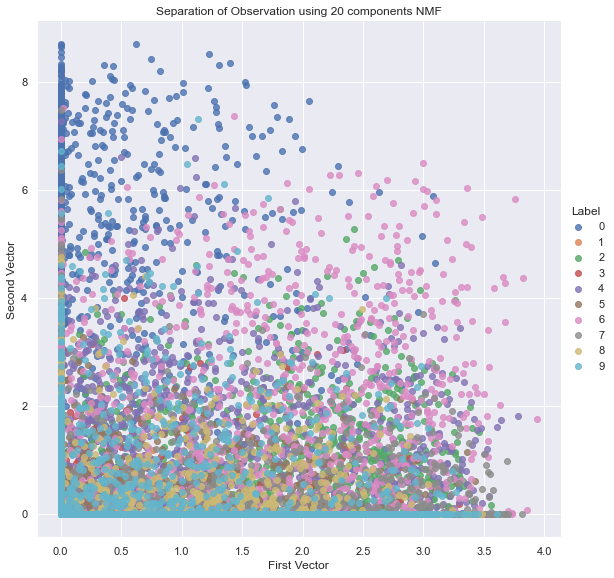

In [38]:
# Plot the obsevation clustering
y_train_NMF_df = pd.Series(data = y_train, index = range(0,len(x_train_NMF)))
scatterPlot(x_train_NMF_df,y_train_NMF_df, "20 components NMF")

***The plot does not show very clearly on 2D vectors how well those observations are separated. But let's just go ahead make predictions for test set, and calculate accuracy, precision, as well as recall scores for test set.***

In [39]:
# Make predictions for test set
x_test_NMF = nmf.transform(x_test)
y_test_pred = nmf.predict(x_test_NMF)
print(y_test_pred)

[3 6 9 ... 5 8 6]


In [40]:
# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')
print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9295238095238095
Precision Score: 0.9293323467539008
Recall Score: 0.9295238095238095


***With just 20 components NMF, our prediction accuracy on test set is about 92.8% which is quite good. But we need to know how many components to include in our NMF factorizaion. A way to find out is to use the elbow plot with reconstruction error to find out the optimal number of components. Here I define a range number of components from 10 to 50. We can include more but it will run very slow. Perhaps it makes more sense to include around 50 components as the maximum number. I use 49 components as maximum because it is 1/16 of the original 784 components.***

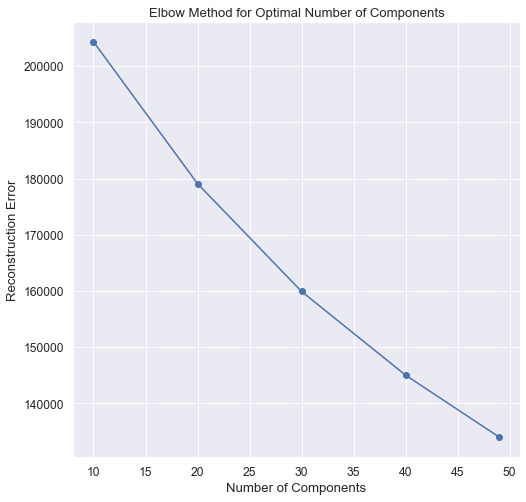

In [71]:
# Define a range of components to evaluate
components_range = [10,20,30,40,49]

# Compute the reconstruction error for each number of components
reconstruction_errors = []
for n_components in components_range:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        nmf = NMF(n_components=n_components, init = None, solver='cd',beta_loss = 'frobenius', random_state=0)
        x_train_nmf = nmf.fit_transform(x_train)
        x_train_reconstructed = np.dot(x_train_nmf, nmf.components_)
        error = np.linalg.norm(x_train - x_train_reconstructed)
        reconstruction_errors.append(error)

# Plot the reconstruction errors
plt.plot(components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Elbow Method for Optimal Number of Components')
plt.show()

The elbow plot shows that as the number of components increase, the error goes down too. But it seems like the optimal number of components is a large number, possibly as much as 784 components so we need to define a number that we can be confident that would gives us a good accuracy but not too slow in computation. Since with just 20 components we already achieved somewhat 92.8% accuracy, let's just stick the 49 as the optimal number of components for fast computation. 

In [42]:
# Create a NMF classifier with 49 components
n_components = 49
nmf = NMFClassifier(n_components = n_components, k =3, random_state = 0)

In [43]:
# NMF fit and transform train set
nmf = nmf.fit_transform(x_train,y_train)
x_train_NMF = nmf.X_train_NMF
x_train_NMF_df = pd.DataFrame(data= x_train_NMF, index = range(0,len(x_train_NMF)))
x_train_NMF_df

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,1.057268,0.000000,0.000000,2.024972,3.000677,0.000000,0.289028,1.739654,1.390440,1.521387,...,0.000000,0.727052,0.613922,0.528914,0.216574,0.000000,1.236149,0.000000,0.724659,0.000000
1,0.000000,1.845778,3.570981,0.517499,0.000000,0.000000,0.000000,2.215623,0.027749,2.068705,...,2.128374,0.000000,0.000000,0.167172,0.874767,0.000000,1.173980,1.563026,0.000000,0.000000
2,0.000000,0.717570,1.666985,0.000000,0.908007,1.182330,2.164917,2.133251,0.959147,2.647983,...,1.791648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234593,0.000000,0.000000
3,0.403540,0.052201,0.000000,0.143052,0.000000,2.767753,0.000000,1.683391,0.000000,1.931916,...,0.000000,0.000000,0.000000,0.303518,0.000000,0.000000,0.000000,0.000000,0.000000,1.095968
4,0.000000,0.000000,3.227975,1.528381,2.250799,1.235217,0.717041,0.000000,0.000000,0.000000,...,0.000000,0.642536,1.410762,0.810702,0.000000,1.246436,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.000000,0.000000,1.420921,0.000000,2.953603,0.000000,2.279436,0.074794,0.710274,1.847217,...,0.000000,1.504813,0.000000,0.000000,0.000000,0.465983,1.461686,1.131459,1.473583,0.000000
20996,1.156782,0.000000,0.000000,0.063898,0.000000,2.859106,0.421503,0.000000,0.000000,0.267106,...,0.000000,0.000000,0.000000,1.548021,0.052573,0.228722,1.093472,0.000000,0.000000,0.000000
20997,0.000000,0.000000,0.724683,0.000000,0.000000,0.000000,0.526896,0.807905,1.150205,1.852129,...,0.000000,0.000539,0.182060,1.705693,1.502986,0.000000,0.069607,0.000000,0.000000,0.349663
20998,0.000000,4.117331,0.000000,2.580508,0.000000,3.151053,0.232130,0.531609,0.000000,1.136874,...,1.523238,0.000000,0.000000,0.028345,0.175348,0.000000,1.337882,1.528329,0.462890,0.678484


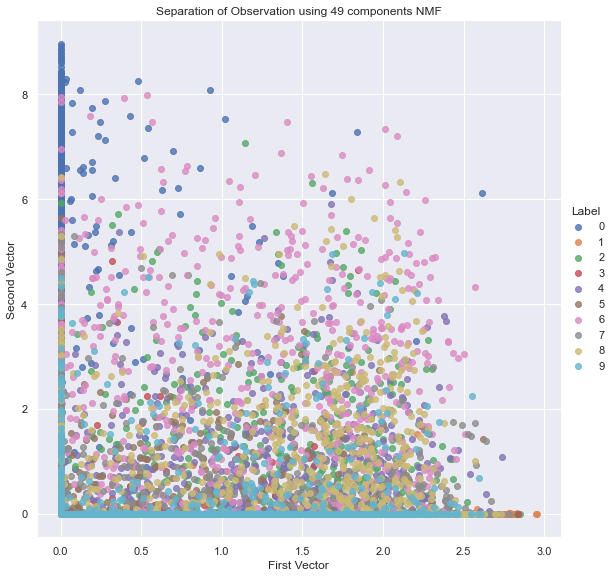

In [44]:
# Plot the obsevation clustering
y_train_NMF_df = pd.Series(data = y_train, index = range(0,len(x_train_NMF)))
scatterPlot(x_train_NMF_df,y_train_NMF_df, "49 components NMF")

***Similar plot to 20 components plot, 49 components plot does not show how well those observations are separated in 2D vectors. I will make predictions for test set, and calucalte accuracy, precision, as well as recall scores for test set.***

In [45]:
# Make predictions for test set
x_test_NMF = nmf.transform(x_test)
y_test_pred = nmf.predict(x_test_NMF)
print(y_test_pred)

[3 6 9 ... 5 8 6]


In [46]:
# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9448571428571428
Precision Score: 0.9449580007827884
Recall Score: 0.9448571428571428


***By using NMF with 49 components (1/16 of the original size), I am able to achive 94.6% accuracy on the test set. This is very good good result considering I only use 1/16 of the number of original components for NMF. Let's plot the confusion matrix for test set.***

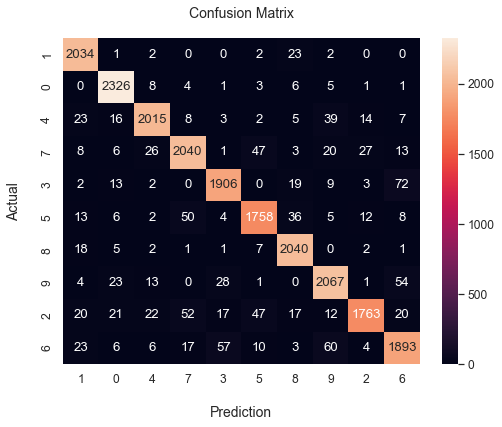

In [47]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

## 3. Clustering
I will use two different clustering methods to find clusters for the observations. And based on the clusters, I will make prediction for each test sample by calculating distances or minimum distances between test samples and clusters centers and find the nearest neighbors.

### Simple clustering based on the mean of each observation clusters.
This is the first clustering method: find the clusters points for each observation, find cluster centers for each label based on the mean of the cluster points, calculate distance  for each between test sample and its train cluster centers, find the nearest neighbors and assigin for predictions. 

In [48]:
# Calculate the cluster centers per class using the mean of the training data points
cluster_centers_per_class = np.array([np.mean(x_train[y_train == label], axis=0) for label in np.unique(y_train)])


# Compute distances between each test sample and the cluster centers
distances_test = cdist(x_test, cluster_centers_per_class , "euclidean")

# Find the nearest cluster for each test sample
nearest_cluster_indices = np.argmin(distances_test, axis=1)

# Assign labels 
y_test_pred = nearest_cluster_indices

In [49]:
# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')
print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.8126190476190476
Precision Score: 0.8155611374521421
Recall Score: 0.8126190476190476


**A simple clustering method based on the mean of each observation clusters gives us not a bad accuracy, roughly 81.3%. However, please note that directly assigning cluster indices as predictions may not always yield accurate results, especially if the clusters do not align perfectly with the class labels. So let's plot the confusion matrix.**

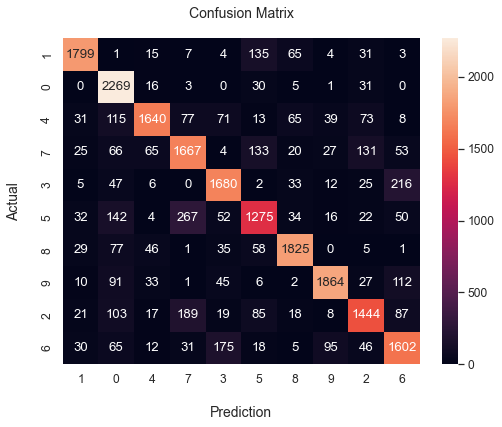

In [50]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

### K-means clustering
This is the second clustering method. So instead, think about what if we find a number of clusters for each label, train a separate classifier for each label clusters to find the closest label for each label based on minimum distance. We have 10 labels, so let's try to find 50 clusters for each label. The steps are: find 50 clusters for each label by using KMeans from sklearn library, train a seperate K-nearest neighbors classifier for the clusters of each label, find the closest label based on the minimum distance between each sample and its clusters, assign closest label as prediction for that sample.

In [51]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

n_clusters_per_label = 50
n_neighbors = 3
num_classes = 10
# Initialize an empty list to store the predicted labels
y_test_pred = []

# Train a separate classifier for each label
classifiers = []
for label in range(num_classes):
    # Get the data points belonging to the current label
    label_data = x_train[y_train == label]

    # Perform K-means clustering on the label data
    kmeans = KMeans(n_clusters=n_clusters_per_label, random_state=0)
    kmeans.fit(label_data)

    # Train a classifier on the cluster centers
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier.fit(kmeans.cluster_centers_, [label] * n_clusters_per_label)
    classifiers.append(classifier)

# Predict labels for the test data
for sample in x_test:
    # Find the closest cluster center
    closest_cluster_label = None
    closest_distance = float('inf')

    for label, classifier in enumerate(classifiers):
        # Predict the label based on the closest cluster center
        distance = np.linalg.norm(sample - classifier._fit_X, axis=1).min()
        
        if distance < closest_distance:
            closest_distance = distance
            closest_cluster_label = label

    # Assign the closest label as the predicted label
    y_test_pred.append(closest_cluster_label)

y_test_pred = np.array(y_test_pred)

In [52]:
# Calculate accuracy, precision and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9461904761904761
Precision Score: 0.9463444813226195
Recall Score: 0.9461904761904761


***K-means clustering method with train set decreases to 500 observations and number of distances to calculate - to just 5,000,000 gives us a quite high accuracy score of 94.6%. Considering we only clustered 50 digits in every label to make prediction, this clustering method gives both accuracy and computing performance. Of course, we can increase the number of clusters to increase the accuracy but it will be a bit slower.Let's draw the confusion matrix.*** 

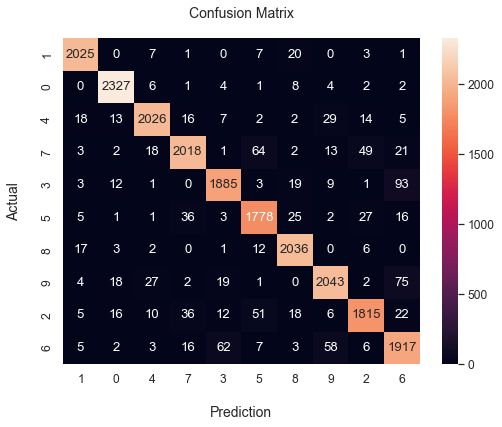

In [53]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

# II. Supervised Learning
I will apply two supervised learning models to fit the train set, make prediction for the test set, and compare with unsupervised learning model.

### Suppor Vector Machine (SVM)
Train a SVC on the train set. Use that to make prediction for test set.

In [54]:
# Train an SVM classifier on the training data
svm = SVC()
svm.fit(x_train, y_train)

SVC()

In [55]:
# Make predictions for test set
y_test_pred = svm.predict(x_test)

In [56]:
# Calculate accuracy, preciosn and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')
print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9694285714285714
Precision Score: 0.9694271270464219
Recall Score: 0.9694285714285714


Quite a good accuracy score of 96.9% from the test set. How about if we use SVM on the transformed PCA train set that we have got above ? After dimensionality reduction, computation could be much faster and we can perhaps improve our accuracy. Let's find out.

In [57]:
# Train an SVM classifier on the transformed PCA training data
svm = SVC()
svm.fit(x_train_PCA, y_train)

SVC()

In [58]:
# Make predictions for test set
y_test_pred = svm.predict(x_test_PCA)

In [59]:
# Calculate accuracy, preciosn and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')
print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9738571428571429
Precision Score: 0.9738597578463076
Recall Score: 0.9738571428571429


***Impressive result by using SVM on PCA training set to make prediction for test set. The accuracy is 97.4% on the test set. Let's plot confusion matrix.***

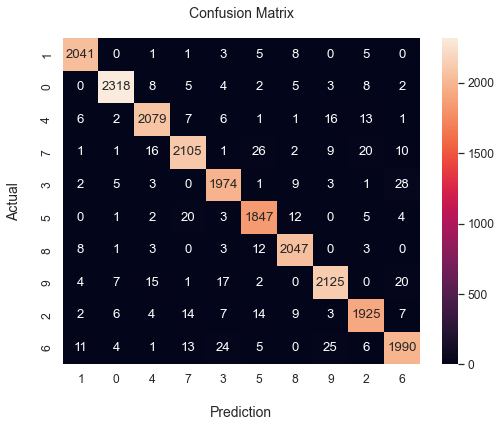

In [60]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

### Random Forest (RF)
Train a RF on train set, use that to predict test set. Calculate accuracy, preciosion and recall for test set.

In [61]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [62]:
# Make predictions for test set
y_test_pred = rf.predict(x_test)

In [63]:
# Calculate accuracy, preciosn and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9578095238095238
Precision Score: 0.9577957756165366
Recall Score: 0.9578095238095238


***Good accuracy score of 95.7% from the test set. Let's draw the confusion matrix.***

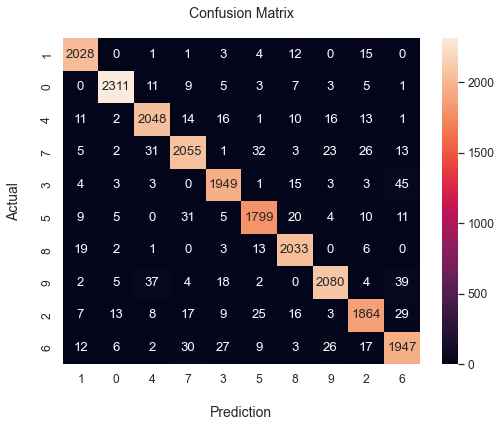

In [64]:
conf_matrix = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_matrix)

#### Hyperparameters Tuning for SVM
Let's apply GridSearchCV to find best parameters for SVM since it is our best model with accuracy. Our data is large, even our train set that was split has like 21000 samples. However when applying GridSearchCV, we can do it with a smaller batch of data such as 5000 samples for faster computation.

In [65]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Create an SVC classifier
svm = SVC()

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

# Create a subset of the training data
limited_x_train = x_train_PCA[:5000]
limited_y_train = y_train[:5000]

# Create GridSearchCV object with limited training set
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3)
grid_search.fit(limited_x_train, limited_y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the SVM model with the best parameters on the full training set
svm_best = SVC(**best_params)
svm_best.fit(x_train_PCA, y_train)

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.9608017172075788


SVC(C=10)

In [66]:
# Make predictions on the test set
y_test_pred = svm_best.predict(x_test_PCA)
# Calculate accuracy, preciosn and recall for test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average = 'weighted')
recall = recall_score(y_test,y_test_pred, average = 'weighted')

accuracy_list.append(accuracy)
precision_list.append(precision)
recall_list.append(recall)

print("Accuracy Score:", accuracy)
print("Precision Score:", precision)
print("Recall Score:", recall)

Accuracy Score: 0.9777142857142858
Precision Score: 0.9777156004564415
Recall Score: 0.9777142857142858


***With best parameters, we can improve our accuracy for test set to 97.8%. It's time to make the prediction for submission.***

# Test.csv Prediction and Submission
Now that I have the best model is to use PCA with 196 components on train.csv dataset to fit and transform, and apply SVM for that PCA matrix to predict the test.csv for submission on Kaggle.

In [67]:
def test_submit(y_pred):
    try:
        submit_df = pd.DataFrame({'ImageId' : range(1,len(y_pred)+1)})
        submit_df['Label'] = y_pred
        submit_df.to_csv("submission.csv", index=False)
        print('File saved to submission.csv')
    except:
        print("Error trying to create submission.csv")

In [68]:
# Fit and transform X_train by using PCA 196 components
X_train_PCA = pca.fit_transform(X_train,Y_train)
# Applying PCA to X_test
X_test_PCA = pca.transform(X_test)
# Fit and transfrom SVC on PCA train dataset
svm_best.fit(X_train_PCA, Y_train)
# Prediction for test dataset
Y_test_pred = svm_best.predict(X_test_PCA)

In [69]:
test_submit(Y_test_pred)
print('Submission Accuracy Score on Kaggle:', 0.98389)

File saved to submission.csv
Submission Accuracy Score on Kaggle: 0.98389


**The submission file has been submitted to Kaggle Competition. The accuracy of the submission file repored by Kaggle is 0.98389 which is roughly 98.4% accuracy. That's a great accuracy score.** 

# Result, Analysis and Discussion 

In [70]:
data = {'Accuracy': accuracy_list, 'Precision': precision_list, 'Recall':recall_list}
result_df = pd.DataFrame(data)
result_df.index = ['PCA', 'SVD','NMF', 'KMeans', 'RF', 'PCA-SVM']
print('Model Results Comparision Table')
result_df

Model Results Comparision Table


,Accuracy,Precision,Recall
PCA,0.961571,0.961793,0.961571
SVD,0.961143,0.961367,0.961143
NMF,0.944857,0.944958,0.944857
KMeans,0.946190,0.946344,0.946190
RF,0.957810,0.957796,0.957810
PCA-SVM,0.977714,0.977716,0.977714


***The table shows that by applying dimensionaltiy reduction such as PCA or SVD, it can correctly predict 96.1% on the test set. Meanwhile, feature extraction like NMF or clustering method like KMeans can label the data correctly 94.6% on the test set. Using supervised model like RF gives us accuracy around 95.7% while the best model is to use PCA for dimensionality reduction and then use SVM to make predictions. The best model gives us an accuracy of 97.8% on the test set. The test set here is half of the train.csv dataset.*** 

**If we have more observations to train, our accuracy will for sure improve. That's we train the best model on the full train dataset and use it to make prediction for the submission on Kaggle. The submission accuracy is 98.4% reported by Kaggle. This tells us that our best model works extremly well. Feel free to try out and submit the file to see the result.** 

## Sources
- Minimum Distance Classifier from the tutorial of the Digit Recognizer Competion on Kaggle at the following link: https://www.kaggle.com/code/olhacher/minimum-distance-classifier
- Chapter 3,5 on Dimensionality Reduction and Clustering of 'Hands-On Unsupervised Learning Using Python' by Ankur A.Patel.